In [ ]:
iFyt = 0.03
iC = 0.05
m=6
pv = pow(1/(1+iFyt),m/12)
tv = 1/(1+iFyt)
deposit = 1

def p(n):
    return deposit*pow(pv,n)

def P(i):
    return iC*deposit*sum([p(i) for i in list(range(0,i+1))])



In [ ]:
import matplotlib.pyplot as plt
import numpy  as np
n=list(range(0,365))
x=np.array(n)
y=np.array([p(i) for i in n])
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
line1 = ax1.plot(x,y,'C1',label='Present Value of FYTs')
ax1.set_xlim([n[0],n[len(n)-1]+1])
ax1.set_xlabel('number of compounds')
ax1.set_ylabel('present value')
ax1.yaxis.label.set_color('C1')

y=np.array([P(i) for i in n])
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(x,y,'C2',label='Total Value of ICs')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlim([n[0],n[len(n)-1]+1])
ax2.set_xlabel('number of compounds')
ax2.set_ylabel('total coupon value')
ax2.yaxis.label.set_color('C2')
fig.legend( loc='center',bbox_to_anchor=(0.7,0.7))


In [ ]:
import matplotlib.pyplot as plt
import numpy  as np
n=list(range(0,365))
x=np.array(n)
y=np.array([p(i) for i in n])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(x,y)
ax[0].set_xlim([n[0],n[len(n)-1]+1])
ax[0].grid()
ax[0].set_title('Present Value of FYT vs Number of Compounds')
ax[0].set_xlabel('number of compounds')
ax[0].set_ylabel('present value')

y=np.array([P(i) for i in n])
ax[1].plot(x,y)
ax[1].set_xlim([n[0],n[len(n)-1]+1])
ax[1].set_ylim([y[0],y[len(y)-1]+10])
ax[1].grid()
ax[1].set_title('Cumulative Value of ICs vs Number of Compounds')
ax[1].set_xlabel('number of compounds')
ax[1].set_ylabel('total coupon value')

fig.tight_layout()


In [30]:
class Asset: 
    def __init__(self,day,num): 
        self.day_issued = day
        self.quantity = num 
        
def calc_present_value(day,maturity_day,amount,rate):
    return amount/pow(1+rate,(max(maturity_day-day,0))/365)

def calc_zcb_present_value(day,maturity_day,amount,rate):
    return calc_present_value(day,maturity_day,amount,rate)

def calc_ic_present_value(day,maturity_day,amount,rate):
    return rate*calc_present_value(day,maturity_day,amount,rate)

def calc_ic_maturity(rate,amount):
    return rate*amount

def calc_total_present_value(day,maturity_day,zcbs_list,ics_list,iZcb,iC):
    total_value = 0
    zcbs_value = 0
    ics_value = 0
    # calc zcb total value
    for i,zcbs in enumerate(zcbs_list):
        days_elapsed = day - zcbs.day_issued
        zcbs_value += calc_zcb_present_value(days_elapsed,maturity_day,zcbs.quantity,iZcb)
    
    # calc ics total value
    for i,ics in enumerate(ics_list):
        days_elapsed = day - ics.day_issued
        ics_present_value = calc_ic_present_value(days_elapsed,maturity_day,ics.quantity,iC)
        ics_maturity = calc_ic_maturity(iC,ics.quantity)
        ics_value += ics_present_value
        #print("ICs Issue Day: {}, ICs at Maturity: {}, ICs at Present Value: {}".format(ics.day_issued, ics_maturity, ics_present_value))
        
    total_value = zcbs_value + ics_value
    
    return total_value, zcbs_value, ics_value
        
def deposit(day,funds):
    zcbs = Asset(day,funds)
    ics = Asset(day,funds) 
    return zcbs,ics

def sell_zcbs(day,maturity_day,zcbs,rate):
    days_elapsed = day - zcbs.day_issued
    return calc_zcb_present_value(days_elapsed,maturity_day,zcbs.quantity,rate)

def run_strategy(iZcb,iC,initial_funds,maturity_day,days,tranch_length):
    funds = initial_funds
    zcbs_list = []
    ics_list = []
    total_values = []
    zcbs_values = []
    ics_values = []
    # Day 0 deposit funds to get zcbs and ics
    zcbs,ics = deposit(0,funds)
    zcbs_list.append(zcbs)
    ics_list.append(ics)

    #print("Day: {}".format(0))
    total_value, zcbs_value, ics_value = calc_total_present_value(0,maturity_day,zcbs_list,ics_list,iZcb,iC)
    #print("Total Value: {}, ZCB Value: {}, IC Value: {}".format(total_value, zcbs_value, ics_value))
    total_values.append(total_value)
    zcbs_values.append(zcbs_value)
    ics_values.append(ics_value)
    for day in days[1:]:
        #print("Day: {}".format(day))
        # check to see if a week has passed
        if day%tranch_length == 0:
            # sell existing zcbs at present value
            zcbs = zcbs_list.pop(0)
            new_funds = sell_zcbs(day,maturity_day,zcbs,iZcb)
            #print("Sold {} zcbs from day {} tranch for {}".format(zcbs.quantity, zcbs.day_issued, new_funds))
            # buy newly issued tranch of zcbs,ics
            new_zcbs,new_ics = deposit(day,new_funds)
            zcbs_list.append(new_zcbs)
            ics_list.append(new_ics)
            #print("Bought {} zcbs and ics".format(zcbs.quantity, zcbs.day_issued, new_funds))

        total_value, zcbs_value, ics_value = calc_total_present_value(day,maturity_day,zcbs_list,ics_list,iZcb,iC)
        #print("Total Value: {}, ZCB Value: {}, IC Value: {}".format(total_value, zcbs_value, ics_value))
        total_values.append(total_value)
        zcbs_values.append(zcbs_value)
        ics_values.append(ics_value)
    return total_values, zcbs_values, ics_values
    

In [33]:
# generate run matrix
results = {}
runs = 3
iZcbs = [0.03, 0.03, 0.03]
iCs = [0.05, 0.04, 0.03]
maturity_days= [365, 365, 365]
tranch_lengths = [7, 7, 7]

for i in range(runs):
    iZcb = iZcbs[i]
    iC = iCs[i]
    initial_funds = 1
    maturity_day=maturity_days[i]
    days=list(range(0,maturity_day))
    tranch_length=tranch_lengths[i]
    total_values, zcbs_values, ics_values = run_strategy(iZcb,iC,initial_funds,maturity_day,days,tranch_length)
    results[i]= (total_values, zcbs_values, ics_values)





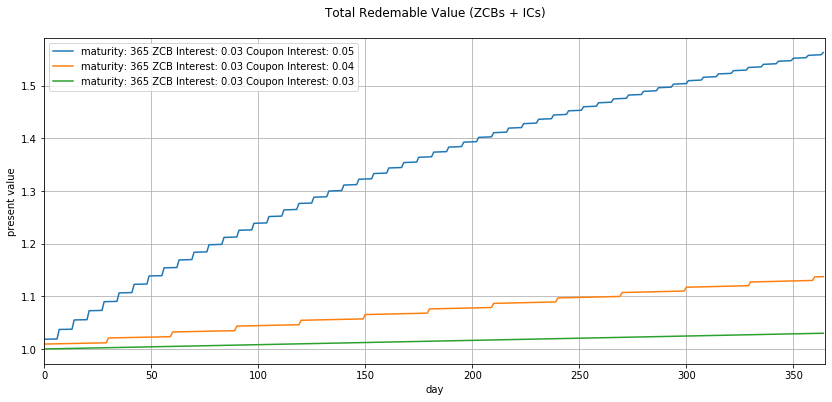

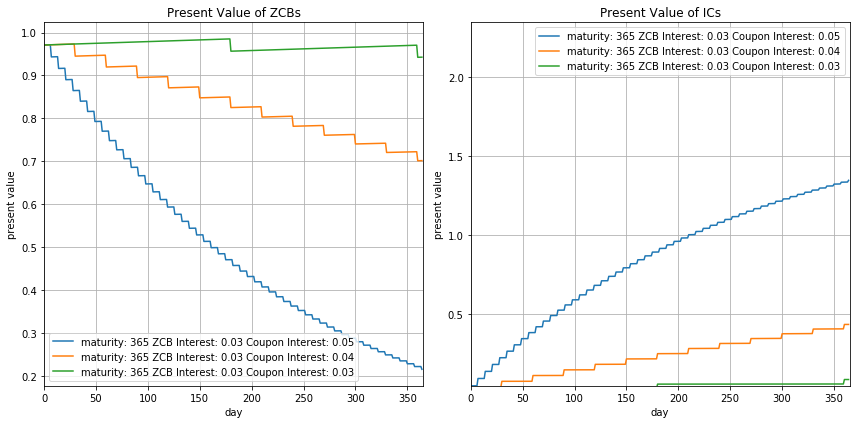

In [40]:
import matplotlib.pyplot as plt
import numpy  as np



x=np.array(days)

y=np.array(results[0][0])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
label0 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[0],iZcbs[0],iCs[0])
ax.plot(x,y,label=label0)
ax.set_xlim([x[0],x[len(x)-1]+1])
y=np.array(results[1][0])
label1 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[1],iZcbs[1],iCs[1])
ax.plot(x,y,label=label1)
y=np.array(results[2][0])
label2 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[2],iZcbs[2],iCs[2])
ax.plot(x,y,label=label2)
ax.grid()
ax.set_title('Total Redemable Value (ZCBs + ICs)\n')
ax.set_xlabel('day')
ax.set_ylabel('present value');
leg = ax.legend();


y=np.array(results[0][1])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
label0 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[0],iZcbs[0],iCs[0])
ax[0].plot(x,y,label=label0)
ax[0].set_xlim([x[0],x[len(x)-1]+1])
y=np.array(results[1][1])
label1 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[1],iZcbs[1],iCs[1])
ax[0].plot(x,y,label=label1)
y=np.array(results[2][1])
label2 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[2],iZcbs[2],iCs[2])
ax[0].plot(x,y,label=label2)
ax[0].grid()
ax[0].set_title('Present Value of ZCBs')
ax[0].set_xlabel('day')
ax[0].set_ylabel('present value')
leg = ax[0].legend();

y=np.array(results[0][2])
label0 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[0],iZcbs[0],iCs[0])
ax[1].plot(x,y,label=label0)
ax[1].set_xlim([x[0],x[len(x)-1]+1])
ax[1].set_ylim([y[0],y[len(y)-1]+1])
y=np.array(results[1][2])
label1 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[1],iZcbs[1],iCs[1])
ax[1].plot(x,y,label=label1)
y=np.array(results[2][2])
label2 = "maturity: {} ZCB Interest: {} Coupon Interest: {}".format(maturity_days[2],iZcbs[2],iCs[2])
ax[1].plot(x,y,label=label2)
ax[1].grid()
ax[1].set_title('Present Value of ICs')
ax[1].set_xlabel('day')
ax[1].set_ylabel('present value')
leg = ax[1].legend();
fig.tight_layout()


In [ ]:
y=np.array([calc_zcb_present_value(day,initial_funds)+calc_ic_present_value(day,initial_funds) for day in days])
